In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Generate 2d zig_zag path
def generate_zig_zag_path(x_start, y_start, n_points, x_d): 
    
    pts = [(x_start, y_start)]
    for i in range(0, n_points):
        if i > 0:
            pt_ = (x_start+i*x_d, (-1)**i*y_start)
            pts.append(pt_)
    return np.array(pts)


def Linear_waypoints(ps, pg, n):
    
    x = np.linspace(ps[0], pg[0], n)
    y = np.linspace(ps[1], pg[1], n)
    z = np.linspace(ps[2], pg[2], n)

    return np.stack((x, y, z), axis=-1)
        
def cast2np(x): 
    return np.array(x)

def parabolic_path(start_point, end_point, height, N, yaw_angle):
    # Extract the coordinates from the input tuples
    x1, y1 = start_point
    x2, y2 = end_point

    # Calculate the vertex (midpoint in x, height from start point in y)
    xv = (x1 + x2) / 2
    yv = y1 + height

    # Set up the system of linear equations
    # Equation 1: y1 = a*x1^2 + b*x1 + c
    # Equation 2: y2 = a*x2^2 + b*x2 + c
    # Equation 3: yv = a*xv^2 + b*xv + c
    A = np.array([
        [x1**2, x1, 1],
        [x2**2, x2, 1],
        [xv**2, xv, 1]
    ])
    B = np.array([y1, y2, yv])

    # Solve the system of equations to find a, b, c
    a, b, c = np.linalg.solve(A, B)
    
    
    # Generate N points along the parabola
    x_points = np.linspace(x1, x2, N)* np.sin(np.radians(yaw_angle))
    y_points = (a * x_points**2 + b * x_points + c)#*np.cos(np.radians(yaw_angle))

    return x_points, y_points

def generate_circular_path(start_pose, radius, num_points=50):
    """
    Generates a circular path from a starting pose.
    
    Parameters:
    - start_pose: Tuple of (x, y, theta) representing the starting position and orientation of the robot.
    - radius: The radius of the circular path.
    - num_points: Number of points to generate on the circular path.
    
    Returns:
    - List of (x, y) tuples representing the points on the circular path.
    """
    # TODO: Make more robust conversion at some point in time
    x_start = start_pose[0]
    y_start = start_pose[1]
    z_start = start_pose[2]
    theta_start = 0; 
    circular_path = []
    
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        x = x_start + radius * math.cos(angle + theta_start) - radius
        y = y_start + radius * math.sin(angle + theta_start) 
        z = z_start

        circular_path.append([x, y, z])
    
    return circular_path

In [6]:
def parabola(x, a=1, b=0, c=0): 
    return a*x**2 + b*x + c 

x = np.linspace(-5, 5, 100)
# Parabola without b and c element 
y = parabola(x, 2, 0, 0)

def poly_f(x, order): 
    return x**order

In [7]:
def quad_bezier(p0, p1, p2, t_min=0, t_max=1): 
    t = np.linspace(t_min, t_max, 100)
    bezier_x = (1-t)*p0[0] + 2*t*(1-t)*p1[0] + t**2*p2[0]
    bezier_y = (1-t)*p0[1] + 2*t*(1-t)*p1[1] + t**2*p2[1]
    return bezier_x, bezier_y

In [9]:
pts = generate_zig_zag_path(0, 1.0, 10, 0.5)

# First one
p0 = cast2np(pts[0, :]) 
p1 = cast2np(pts[1, :]) 
p2 = cast2np(pts[2, :])
# Second one
b0 = cast2np(pts[2, :])
b1 = cast2np(pts[3, :])
b2 = cast2np(pts[4, :])
# Third one
c0 = cast2np(pts[4, :])
c1 = cast2np(pts[5, :])
c2 = cast2np(pts[6, :])
# Fourth one
d0 = cast2np(pts[6, :])
d1 = cast2np(pts[7, :])
d2 = cast2np(pts[8, :])

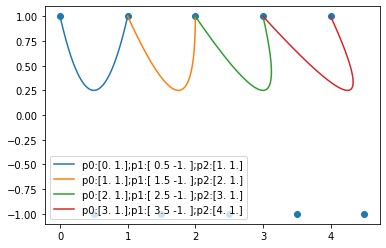

In [10]:
#p1 = p1 + np.array([0, 0.1])
bzr_x, bzr_y = quad_bezier(p0, p1, p2, t_min=0, t_max=1)
#b1 = b1 + np.array([0, 0.05])
pzr_x, pzr_y = quad_bezier(b0, b1, b2)
czr_x, czr_y = quad_bezier(c0, c1, c2)
dzr_x, dzr_y = quad_bezier(d0, d1, d2)
plt.figure()
plt.scatter(pts[:, 0], pts[:, 1])
plt.plot(bzr_x, bzr_y, label=f'p0:{p0};p1:{p1};p2:{p2}')
plt.plot(pzr_x, pzr_y, label=f'p0:{b0};p1:{b1};p2:{b2}')
plt.plot(czr_x, czr_y, label=f'p0:{c0};p1:{c1};p2:{c2}')
plt.plot(dzr_x, dzr_y, label=f'p0:{d0};p1:{d1};p2:{d2}')
plt.legend()
# https://math.umd.edu/~immortal/MATH431/book/ch_bezier.pdf
# Figure out why are they skewed to this point? Hmm... 

In [11]:
import yaml

def load_states_from_yaml(yaml_file):
    with open(yaml_file, 'r') as file:
        data = yaml.safe_load(file)
    
    states = []
    for item in data:
        state = {
            'State': item['State'],
            'Position': {
                'x': item['Position'][0],
                'y': item['Position'][1],
                'z': item['Position'][2]
            },
            'Velocity': {
                'x': item['Velocity'][0],
                'y': item['Velocity'][1],
                'z': item['Velocity'][2]
            },
            'Acceleration': {
                'x': item['Acceleration'][0],
                'y': item['Acceleration'][1],
                'z': item['Acceleration'][2]
            }
        }
        states.append(state)
    
    return states

def plot_trajectory(states):
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    titles = ['Position', 'Velocity', 'Acceleration']
    labels = ['X', 'Y', 'Z']

    for i in range(3):  # Iterate over columns (Position, Velocity, Acceleration)
        for j in range(3):  # Iterate over rows (X, Y, Z)
            ax = axs[j, i]
            ax.set_title(f"{titles[i]} {labels[j]}")

            # Extract data for the current subplot
            data = [state[titles[i]][labels[j].lower()] for state in states]

            # Plot the data
            ax.plot(range(len(states)), data, marker='o', linestyle='-', color='b')
            ax.set_xlabel('Time')
            ax.set_ylabel(f'{titles[i]} {labels[j]}')
            
    plt.tight_layout()
    plt.show()
            
def plot_trajectories(states1, states2):
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    titles = ['Position', 'Velocity', 'Acceleration']
    labels = ['X', 'Y', 'Z']

    for i in range(3):  # Iterate over columns (Position, Velocity, Acceleration)
        for j in range(3):  # Iterate over rows (X, Y, Z)
            ax = axs[j, i]
            ax.set_title(f"{titles[i]} {labels[j]}")
            
            # Extract data for the current subplot from the first set of states
            data1 = [state[titles[i]][labels[j].lower()] for state in states1]
            # Extract data for the current subplot from the second set of states
            data2 = [state[titles[i]][labels[j].lower()] for state in states2]

            # Plot the data from the first set of states in blue
            ax.plot(range(len(states1)), data1, marker='o', linestyle='-', color='b', label='Linear')
            # Plot the data from the second set of states in red
            ax.plot(range(len(states2)), data2, marker='o', linestyle='-', color='r', label='Nonlinear')
            
            ax.set_xlabel('Time')
            ax.set_ylabel(f'{titles[i]} {labels[j]}')
            ax.legend()

    plt.tight_layout()
    plt.show()

lin_states = load_states_from_yaml("./lin_opt_states3.yaml")
nonlin_states = load_states_from_yaml("./non_lin_opt_states3.yaml")

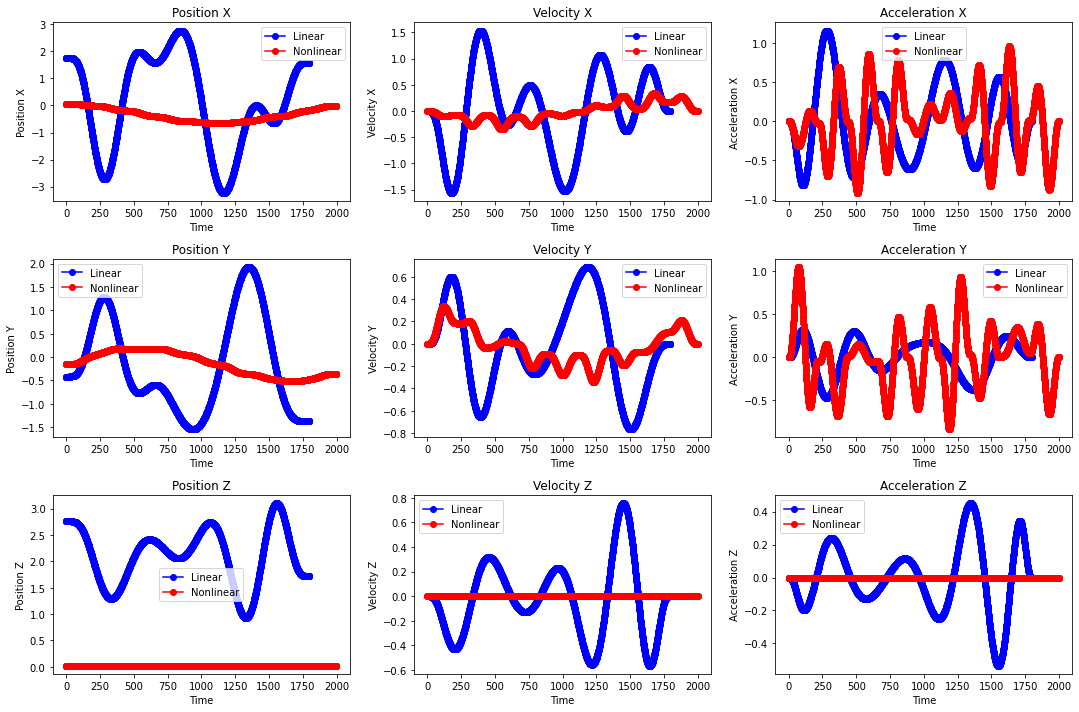

<Figure size 432x288 with 0 Axes>

In [12]:
plot_trajectories(lin_states, nonlin_states)
plt.savefig("linopt_vs_nonlinopt1.png")